In [1]:
##Estimación de pobreza de adecuación energética de acuerdo con Evalúa CDMX
#Se borra todo lo que se encuentra en el entorno

#rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr,showtext,gt)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)

#Fuente para los gráficos
font_add_google("Poppins", "pop")
showtext_auto()

Cargando paquete requerido: pacman

Using GitHub PAT from the git credential store.




rlang  (1.1.4 -> 1.1.6) [CRAN]
glue   (1.7.0 -> 1.8.0) [CRAN]
cli    (3.6.3 -> 3.6.5) [CRAN]
tibble (3.2.1 -> 3.3.0) [CRAN]


Installing 4 packages: rlang, glue, cli, tibble

Warning message:
"package 'tibble' is in use and will not be installed"
Installing packages into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'glue' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glue'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\glue\libs\x64\glue.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\glue\libs\x64\glue.dll: Permission denied"
Warning message:
"restored 'glue'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"



The downloaded binary packages are in
	C:\Users\claud\AppData\Local\Temp\RtmpKIMknl\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\claud\AppData\Local\Temp\RtmpKIMknl\remotes9581c1d52af\cpyp-ipdp-funcionespgd-3fffa52/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



In [2]:
# Definir URL base y parte intermedia
url_basica <- "https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte <- "microdatos/enigh"

# Definir los años y los tipos de archivos a descargar
years <- c("2018", "2020", "2022","2024")
tipos <- c("ns_viviendas", "ns_poblacion")  # Tipos de archivos

# Crear la carpeta de destino si no existe
if (!dir.exists("data")) {
  dir.create("data")
}

# Descargar, descomprimir y renombrar los archivos
for (year in years) {
  for (tipo in tipos) {
    # Construir URL y nombres de archivo
    url <- paste0(url_basica, year, "/", segunda_parte, year, "_", tipo, "_csv.zip")
    zip_destfile <- paste0("data/", year, "_", tipo, ".zip")

    # Descargar solo si el archivo no existe
    if (!file.exists(zip_destfile)) {
      download.file(url, destfile = zip_destfile, mode = "wb")
    } else {
      message("Archivo ya descargado: ", zip_destfile)
    }

    # Extraer archivos en una subcarpeta específica
    extract_dir <- paste0("data/", year, "_", tipo)
    if (!dir.exists(extract_dir)) {
      dir.create(extract_dir)
    }

    unzip(zip_destfile, exdir = extract_dir)

    # Buscar el archivo CSV dentro de la carpeta extraída
    extracted_files <- list.files(extract_dir, pattern = "\\.csv$", full.names = TRUE)

    if (length(extracted_files) == 1) {
      # Determinar el nuevo nombre con formato adecuado
      new_name <- paste0("data/", tipo, "_", year, ".csv")

      # Mover el archivo al directorio principal y renombrarlo
      file.rename(extracted_files, new_name)

      message("Archivo renombrado y movido: ", new_name)
    } else {
      message("Error: No se encontró un archivo CSV único en ", extract_dir)
    }
  }
}


Archivo ya descargado: data/2018_ns_viviendas.zip

Archivo renombrado y movido: data/ns_viviendas_2018.csv

Archivo ya descargado: data/2018_ns_poblacion.zip

Archivo renombrado y movido: data/ns_poblacion_2018.csv

Archivo ya descargado: data/2020_ns_viviendas.zip

Archivo renombrado y movido: data/ns_viviendas_2020.csv

Archivo ya descargado: data/2020_ns_poblacion.zip

Archivo renombrado y movido: data/ns_poblacion_2020.csv

Archivo ya descargado: data/2022_ns_viviendas.zip

Archivo renombrado y movido: data/ns_viviendas_2022.csv

Archivo ya descargado: data/2022_ns_poblacion.zip

Archivo renombrado y movido: data/ns_poblacion_2022.csv

Archivo ya descargado: data/2024_ns_viviendas.zip

Archivo renombrado y movido: data/ns_viviendas_2024.csv

Archivo ya descargado: data/2024_ns_poblacion.zip

Archivo renombrado y movido: data/ns_poblacion_2024.csv



In [101]:
estima_pobreza_energetica <- function(year, variable) {

  # Procesar vivienda (parsing con as.numeric según año)
  vivienda <- read_csv(paste0("data/ns_viviendas_", year, ".csv"), show_col_types = FALSE) %>%
    {
      if (year <= 2022) {
        mutate(.,
          disp_elect = as.numeric(disp_elect),
          focos_inca = as.numeric(focos_inca),
          focos_ahor = as.numeric(focos_ahor),
          num_cuarto = as.numeric(num_cuarto),
          bano_comp  = as.numeric(bano_comp),
          bano_excus = as.numeric(bano_excus),
          bano_regad = as.numeric(bano_regad),
          combustible = as.numeric(combustible)
        )
      } else if (year >= 2024) {
        mutate(.,
          disp_elect = as.numeric(disp_elect),
          focos      = as.numeric(focos),
          focos_ahor = as.numeric(focos_ahor),
          num_cuarto = as.numeric(num_cuarto),
          bano_comp  = as.numeric(bano_comp),
          bano_excus = as.numeric(bano_excus),
          bano_regad = as.numeric(bano_regad),
          combus     = as.numeric(combus)
        )
      }
    } %>%
    mutate(
      AElj = case_when(
        disp_elect == 5 ~ 0,              # no tiene luz eléctrica
        disp_elect %in% c(3, 4) ~ 0.5,    # panel solar u otra fuente
        disp_elect %in% c(1, 2) ~ 1,      # servicio público / planta particular
        TRUE ~ NA_real_
      )
    ) %>%

    # --- Logro de focos ---
    mutate(
      CTj = num_cuarto,

      Focos = if (year <= 2022) {
        replace_na(focos_inca, 0) + replace_na(focos_ahor, 0)
      } else if (year >= 2024) {
        replace_na(focos, 0) + replace_na(focos_ahor, 0)
      },

      # baños: (.=0) y conteo
      bano_comp  = replace_na(bano_comp,  0),
      bano_excus = replace_na(bano_excus, 0),
      bano_regad = replace_na(bano_regad, 0),
      num_bano   = bano_comp + bano_excus + bano_regad,

      # cuartos totales incluyendo baños
      CTBj = CTj + num_bano,

      # norma (focos por cuarto incluyendo baños)
      Fj_N = 1.25,

      # indicador logro de focos
      LFj  = if_else(CTBj > 0, (Focos / CTBj) / Fj_N, NA_real_),

      # reescalado: máximo 2
      LFj_P = if_else(LFj > 1, pmin(1 + (LFj - 1) / 3, 2), LFj),

      # indicador integral de logro de electricidad y su privación
      LIEI = AElj * LFj_P,
      PIEI = 1 - LIEI
    ) %>%

    # --- Fuente de energía para cocinar (2024+: 'combus' con 7 = No cocinan) ---
    mutate(
      comb_num = if (year >= 2024) combus else combustible,
      CK = case_when(
        comb_num %in% c(3, 4, 5) ~ 3,        # gas tanque / natural / electricidad (norma)
        comb_num %in% c(1, 2, 6,7) ~ 1,     # leña, carbón, otro, NO cocinan (7)
        TRUE ~ NA_real_
      ),
      ACK = CK / 3,
      PCK = 1 - ACK,

      # adecuación energética y carencia
      AENj = ACK * 0.30 + LIEI * 0.70,
      CENj = 1 - AENj,
      year = year
    ) %>%

    # Selección de variables (igual que tenías)
    {
      if (year < 2022) select(., folioviv, AElj, LFj_P, LIEI, PIEI, ACK, PCK, AENj,CTBj ,CENj,Focos,comb_num, factor, upm, est_dis) else
        select(., folioviv, AElj, LFj_P, LIEI, PIEI, ACK, PCK, AENj, CENj,Focos,comb_num,CTBj)
    }

  # Población
  pob <- read_csv(paste0("data/ns_poblacion_", year, ".csv"), show_col_types = FALSE) %>%
    janitor::clean_names() %>%
    # Filtrar parentescos que no pertenecen al núcleo familiar
    filter(!(parentesco >= 400 & parentesco < 500) & !(parentesco >= 700 & parentesco < 800)) %>%
    # Crear clave de entidad
    mutate(
      cve_ent = case_when(
        nchar(folioviv) == 9 ~ paste0("0", substr(folioviv, 1, 1)),
        nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
      )
    ) %>%
    # Pegar vivienda
    left_join(vivienda, by = "folioviv") %>%
    mutate(
      # Estratos de carencia energética (tu lógica original)
      E_CENJ = case_when(
        CENj <= -0.5 ~ 6,
        CENj > -0.5 & CENj <= -0.1 ~ 5,
        CENj > -0.1 & CENj <= 0 ~ 4,
        CENj > 0 & CENj <= (1/3) ~ 3,
        CENj > (1/3) & CENj <= 0.5 ~ 2,
        CENj > 0.5 & CENj <= 1 ~ 1,
        TRUE ~ NA_real_
      ),
      # Pobreza energética
      pobreza_cenj = case_when(
        E_CENJ >= 4 ~ 0,
        E_CENJ <= 3 ~ 1,
        TRUE ~ NA_real_
      )
    )

  # Diseño muestral
  diseno <- pob %>%
    as_survey_design(
      ids = upm,
      strata = est_dis,
      weights = factor,
      nest = TRUE
    )

  # Estimaciones
  resultado <- if (variable == "pobreza_energetica") {
    # diseno%>%
    # filter(cve_ent == "09") %>%
    # group_by(CTBj) %>%
    # summarise(
    #   pob = survey_total(vartype = "cv"),
    #   porcentaje = survey_prop(vartype = "cv")
    # )%>%
    # mutate(porcentaje = porcentaje * 100, year = year) 
    diseno %>%
      filter(cve_ent == "09") %>%
      group_by(pobreza_cenj) %>%
      summarise(
        pob = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = porcentaje * 100, year = year) %>%
      filter(pobreza_cenj == 1)
  
  } else {
    stop("Variable no reconocida")
  }

  return(resultado)
}

In [102]:
tabla_pobreza <- map_dfr(years, estima_pobreza_energetica, variable = "pobreza_energetica")
tabla_pobreza

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or mo

pobreza_cenj,pob,pob_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,4412792,0.03827475,47.984627,0.03202021,2018
1,4576102,0.03400964,49.521462,0.02907445,2020
1,4335357,0.03611505,46.594151,0.03099795,2022
1,276330,0.15341178,2.956804,0.15097855,2024


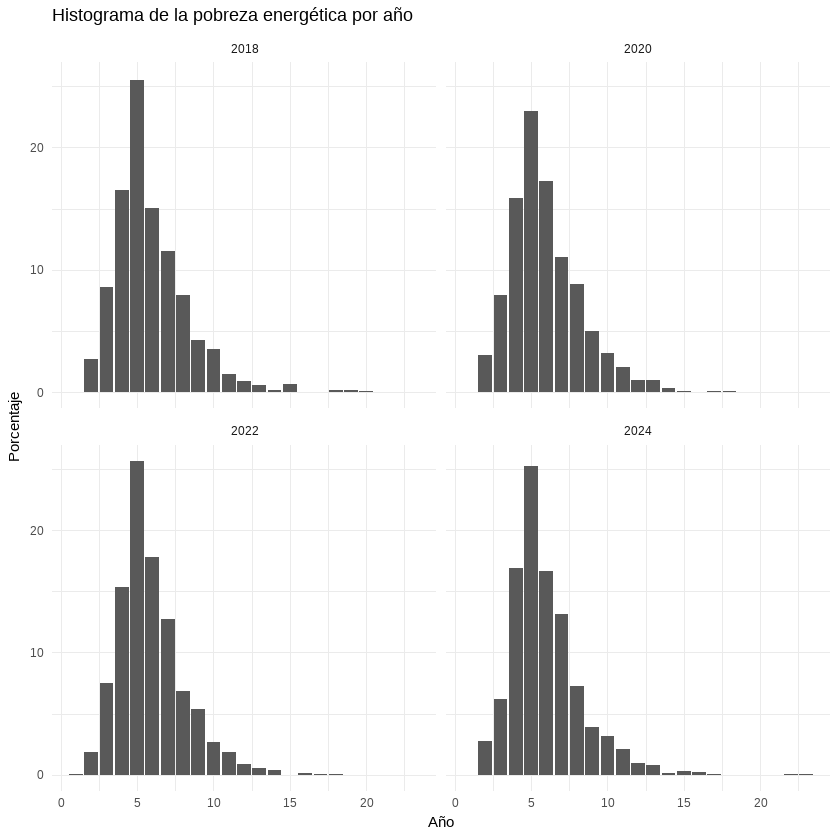

In [100]:
#Histograma de la tabla_pobreza por año

tabla_pobreza%>%
  ggplot(aes(x = CTBj, y = porcentaje)) +
  geom_bar(stat = "identity") +
  labs(title = "Histograma de la pobreza energética por año",
       x = "Año",
       y = "Porcentaje",
       fill = "Estrato de carencia energética") +
  theme_minimal()+
  facet_wrap(~ year)

In [88]:
vivienda2024<-read_csv(file = "data/ns_viviendas_2024.csv", show_col_types = FALSE)
vivienda2022<-read_csv(file = "data/ns_viviendas_2022.csv", show_col_types = FALSE)

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


In [89]:
dm24<-vivienda2024%>%
as_survey_design(
    ids = upm,
    strata = est_dis,
    weights = factor,
    nest = TRUE
)

In [90]:
dm22<-vivienda2022%>%
  as_survey_design(
    ids = upm,
    strata = est_dis,
    weights = factor,
    nest = TRUE
  )

In [91]:
dm22%>%
group_by(focos_inca)%>%
  summarise(focos=survey_total())%>%
  ungroup()%>%
  janitor::adorn_totals()

focos_inca,focos,focos_se
<chr>,<dbl>,<dbl>
0,29380667,126733.4483
1,1664383,37215.5987
2,1723283,38766.5830
3,1324629,33847.1283
4,942661,27510.0456
5,676542,22573.3442
6,436081,17159.8359
7,212831,11995.5492
8,178831,11499.9364


In [92]:
dm24%>%
group_by(focos)%>%
  summarise(viviendas=survey_total())%>%
  janitor::adorn_totals()

focos,viviendas,viviendas_se
<chr>,<dbl>,<dbl>
0,1711,689.4324
1,311599,15625.9458
2,1327654,37453.7199
3,2614970,49889.5818
4,4272583,64667.1645
5,4800352,66122.7594
6,5427772,73035.1177
7,4097148,66984.9123
8,4119610,68616.7758


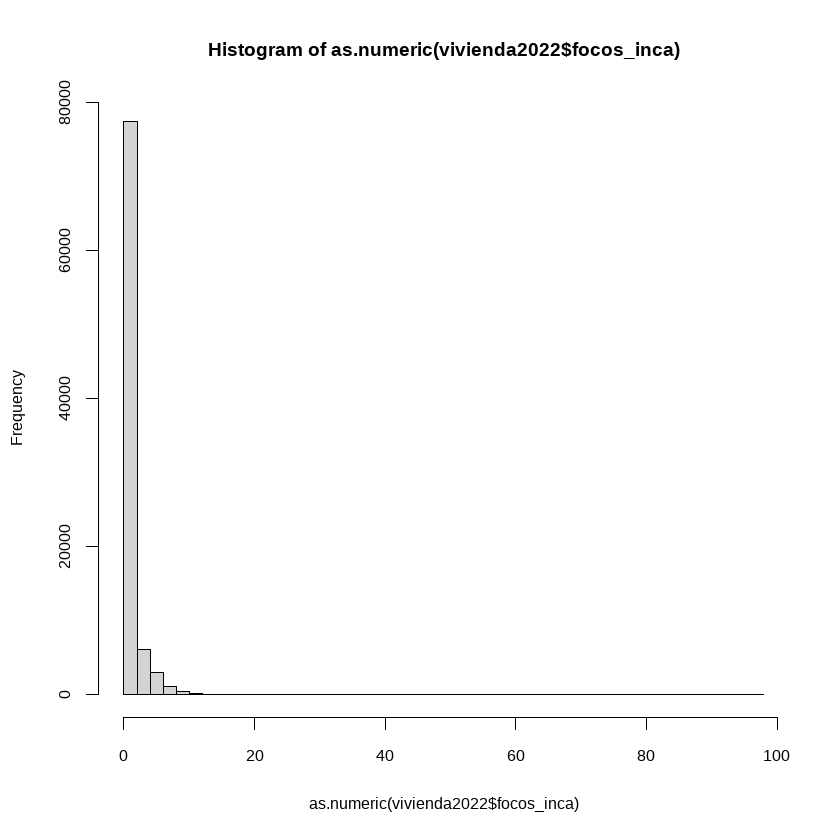

In [93]:
#histograma de focos

hist(as.numeric(vivienda2022$focos_inca),breaks=50)

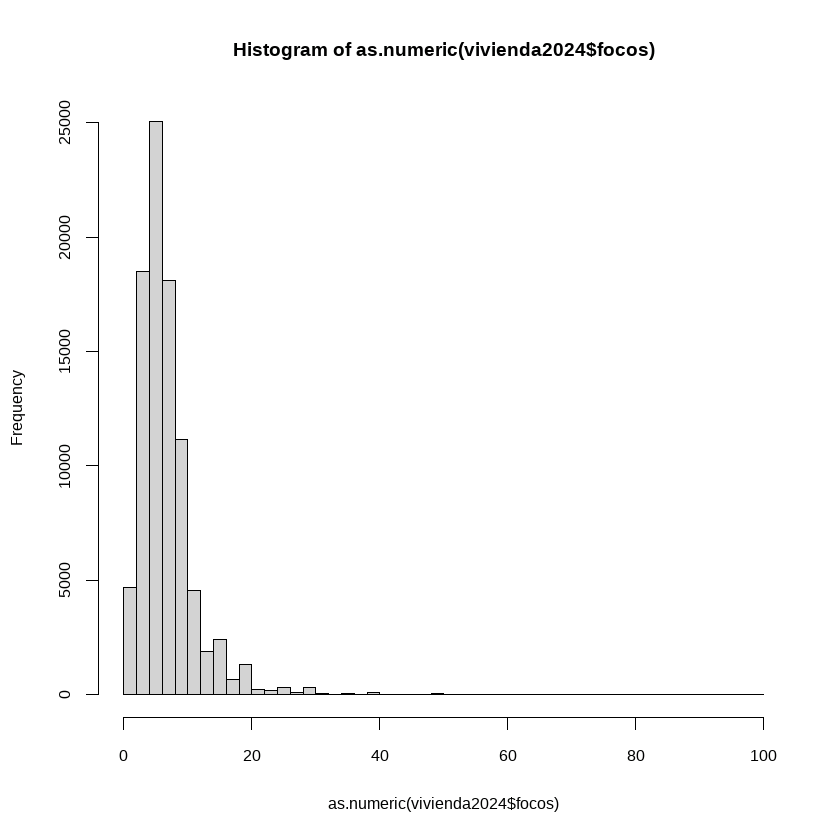

In [94]:
hist(as.numeric(vivienda2024$focos),breaks=50)